1.
В данном задании вам нужно будет

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)


#### Описание данных:
* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import pandas as pd

In [2]:
ab_data = pd.read_csv('ab_browser_test.csv')
ab_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [3]:
control_click = sum(ab_data[ab_data['slot'] == 'control'].n_clicks)
exp_click = sum(ab_data[ab_data['slot'] == 'exp'].n_clicks)
answer_1 = round((exp_click*100/control_click - 100), 3)
answer_1

1.614

2.
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [4]:
import numpy as np

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
control_val = ab_data[ab_data['slot'] == 'control'].n_clicks.values
exp_val = ab_data[ab_data['slot'] == 'exp'].n_clicks.values

control_median_scores = list(map(np.median, get_bootstrap_samples(control_val, 500)))
exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_val, 500)))

print("95% доверительый интервал для медианных значений кликов в группе control:",  stat_intervals(control_median_scores, 0.05))
print("95% доверительый интервал для медианных значений кликов в группе exp:",  stat_intervals(exp_median_scores, 0.05))

95% доверительый интервал для медианных значений кликов в группе control: [4. 4.]
95% доверительый интервал для медианных значений кликов в группе exp: [5. 5.]


In [8]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(control_median_scores, exp_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1. 1.]


In [7]:
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control_val, 500)))
exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_val, 500)))

print("95% доверительый интервал для средних значений кликов в группе control:",  stat_intervals(control_mean_scores, 0.05))
print("95% доверительый интервал для средних значений кликов в группе exp:",  stat_intervals(exp_mean_scores, 0.05))

95% доверительый интервал для средних значений кликов в группе control: [11.2062366  11.35577571]
95% доверительый интервал для средних значений кликов в группе exp: [11.50145367 11.66179523]


In [9]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(control_mean_scores, exp_mean_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [0.20410455 0.40983457]


3.
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

In [10]:
import matplotlib.pyplot as plt

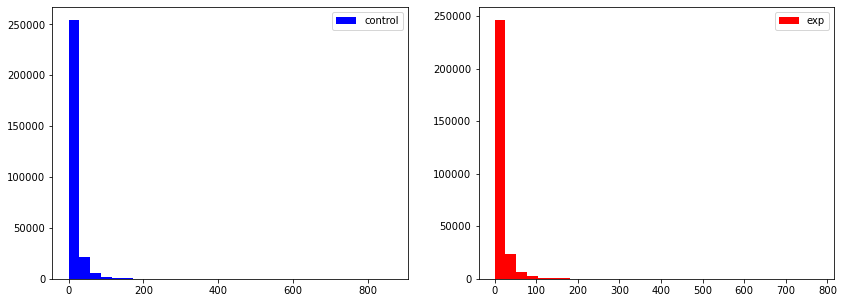

In [22]:
plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plt.hist(ab_data[ab_data['slot'] == 'control'].n_clicks, bins = 30, color = 'b', label = 'control')
plt.legend()

plt.subplot(1,2,2)
plt.hist(ab_data[ab_data['slot'] == 'exp'].n_clicks, bins = 30, color = 'r', label = 'exp')
plt.legend()

plt.show()

4.
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}} $ , то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:
* $\bar{\chi}$ — среднее значение в выборке — было распределено нормально $\mathcal{N}(\mu ,\frac{\sigma ^{2}}{n})$
* $\frac{n}{\sigma ^{2}} S^{2}$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n−1$ степенями свободы $\chi ^{2}(n−1)$

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

* Получите из данных n_boot_samples псевдовыборок.
* По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
* Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
* Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

np.random.seed(0)
n_boot_samples = 500

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

#### Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения $\chi_{i}$. Именно из-за этого предположения мы имеем, что $\sum_{i}^{} \chi _{i} \sim \mathcal{N}(n\mu , n\sigma ^{2})$ в силу линейности матожидания, независимости всех $\chi_{i}$ между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n} \sum_i X_i - \mu ~\sim~ \mathcal{N}(0, \frac{\sigma^2}{n} )$

Заметим теперь, что следующие распределения эквивалентны $\mathcal{N} (0, \frac{\sigma^2}{n}) \sim \sqrt{\frac{\sigma^2}{n}} \mathcal{N}(0, 1)$

То есть другими словами мы получили, что исходная статистика $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$ распределена как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2n} { n \sigma^2} } } ~\sim~ \frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2} { \sigma^2} } } $

Вспомним, что распределение Стьюдента с $n-1$ степенями свободы определяется как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \chi^2 / (n-1) } } $. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно $\chi_{i}$ были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [25]:
np.random.seed(0) 
n_boot_samples = 500

control_bootstrap = get_bootstrap_samples(control_val, n_boot_samples)
control_bootstrap.shape

(500, 284554)

In [27]:
control_mean = list(map(np.mean, control_bootstrap))

In [32]:
control_boot_chi_squared = list(map((lambda x: sum((x - control_mean)**2)), control_bootstrap.reshape(-1)))

KeyboardInterrupt: 

In [ ]:
from scipy.stats import probplot

In [ ]:
probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared)-1), plot = plt)

In [ ]:
probplot(control_mean, dist="chi2", sparams=(len(control_mean)-1), plot = plt)

5.
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [33]:
control_data = ab_data[ab_data['slot'] == 'control']
exp_data = ab_data[ab_data['slot'] == 'exp']

control_user_cl = control_data.groupby('userID').n_clicks.sum()
exp_user_cl = exp_data.groupby('userID').n_clicks.sum()

len(control_user_cl), len(exp_user_cl)

(284392, 281450)

In [34]:
from scipy.stats import mannwhitneyu

In [36]:
stat, p = mannwhitneyu(control_user_cl, exp_user_cl)
print('Statistics=%f, p=%f' % (stat, p))

Statistics=38901259929.000000, p=0.000000


6.
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha$=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [81]:
control_user_br = ab_data[ab_data['slot'] == 'control']
exp_user_br = ab_data[ab_data['slot'] == 'exp']

len(control_user_br), len(exp_user_br)

(284554, 281580)

In [95]:
p_value = []
for col in list(control_user_br.browser.unique()):
    stat, p = mannwhitneyu(control_user_br[(control_user_br['browser'] == col) & (control_user_br['n_clicks'] != 0)].n_clicks, 
                           exp_user_br[(exp_user_br['browser'] == col) & (exp_user_br['n_clicks'] != 0)].n_clicks)
    p_value.append(p)
    
p_value

[0.16493530767704329,
 1.2219033063170227e-95,
 0.2923599574344776,
 0.4345606087024535,
 0.2908339259636146,
 0.06745842337310633]

In [98]:
from statsmodels.stats.multitest import multipletests
reject, p_adjusted, _, _ = multipletests(p_value, alpha=0.05, method='bonferroni')
list(p_adjusted)

[0.9896118460622597, 7.331419837902136e-95, 1.0, 1.0, 1.0, 0.404750540238638]

7.
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [ ]:
control_click = sum(ab_data[ab_data['slot'] == 'control'].n_clicks)
exp_click = sum(ab_data[ab_data['slot'] == 'exp'].n_clicks)
answer_1 = round((exp_click*100/control_click - 100), 3)
answer_1

In [107]:
querries = pd.DataFrame(columns = ['browser', 'control', 'exp'])
for i, col in enumerate(list(ab_data.browser.unique())):
    control_nonq_click = sum(ab_data[(ab_data['slot'] == 'control') & (ab_data['browser'] == col)].n_nonclk_queries)
    control_q_click = sum(ab_data[(ab_data['slot'] == 'control') & (ab_data['browser'] == col)].n_queries)

    exp_nonq_click = sum(ab_data[(ab_data['slot'] == 'exp') & (ab_data['browser'] == col)].n_nonclk_queries)
    exp_q_click = sum(ab_data[(ab_data['slot'] == 'exp') & (ab_data['browser'] == col)].n_queries)
    control_q = control_non_click*100/control_q_click
    exp_q = exp_nonq_click*100/exp_q_click
    querries.loc[i] = [col, control_q, exp_q]

querries

,browser,control,exp
0,Browser #2,245.412273,44.982747
1,Browser #4,131.000942,45.142942
2,Browser #14,496.296402,43.755617
3,Browser #17,665.141369,36.937413
4,Browser #20,717.215822,38.977376
5,Browser #22,178.813205,39.853947
